\newpage

# 0 Setup {-}

In [3]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
assert tf.__version__ == "1.13.1"

# ignore tensorflow depreciation warnings
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## 0.1 Plotting Functions {-}

In [21]:
def plot_loss(train_loss, valid_loss=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    
    x = np.arange(0, len(train_loss), 1)
    ax.plot(x, train_loss, label="Training Loss")
    if not valid_loss is None:
        ax.plot(x, valid_loss, label="Valdation Loss")
    
    ax.set_title("Loss" if title == None else title)
    ax.set_xlabel("Updates")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper right")
    
def plot_cluster(K, MU, S, colors=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    
    colors = [None]*K if colors is None else colors
    for i in range(K):
        x, y = S[i][:,0], S[i][:,1]
        ax.scatter(x, y, c=colors[i], alpha=0.5, label=str(i+1), zorder=0)
        ax.scatter(MU[i][0], MU[i][1], c='black', marker='x', s=50, zorder=100)
    
    ax.set_title(title)
    ax.legend(fontsize="small")

\newpage

## 0.2 Helper Functions {-}

In [6]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
    """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

    Args:
        input_tensor: The tensor to reduce. Should have numeric type.
        reduction_indices: The dimensions to reduce. 
        keep_dims: If true, retains reduced dimensions with length 1.
    Returns:
        The reduced tensor.
    """
    max_input_tensor1 = tf.reduce_max(input_tensor, reduction_indices, keep_dims=keep_dims)
    max_input_tensor2 = max_input_tensor1
    if not keep_dims:
        max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
    return tf.log(
            tf.reduce_sum(
              tf.exp(input_tensor - max_input_tensor2),
              reduction_indices,
              keep_dims=keep_dims)) + max_input_tensor1

def logsoftmax(input_tensor):
    """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

    Args:
        input_tensor: Unnormalized log probability.
    Returns:
        normalized log probability.
    """
    return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

\newpage

In [7]:
def get_clusters_Kmeans(K, MU, X):
    """ Given a set of MUs, computes optimal clusters of X 
    """
    
    # getting square pairwise distances
    pair_dist = tf.Session().run(distanceFunc_Kmeans(X, MU))
        
    # getting most likely cluster by index
    S_indices = np.argmin(pair_dist, axis=1)
    
    # getting list of actual data grouped by cluster
    S = [None]*K
    for i in range(K):
        S[i] = X[S_indices == i] 
    
    return S

In [8]:
def get_clusters_GMM(K, MU, sigma, log_pi, X):
    """ Given a set of MUs, computes most likely clusters of X 
    """
    
    # getting posterior distribution
    log_PDF = tf.Session().run(log_GaussPDF(X, MU, sigma))
    log_post = tf.Session().run(log_posterior(log_PDF, log_pi))
    
    # getting most likely cluster by index
    S_indices = np.argmax(log_post, axis=1)
    
    # getting list of actual data grouped by cluster
    S = [None]*K
    for i in range(K):
        S[i] = X[S_indices == i] 
    
    return S

In [9]:
def cluster_percentages(K, S):
    """ Computes percentage of data in each cluster S[i]
    """
    total = 0.0
    percentages = np.zeros(K)
    for i in range(K):
        total += S[i].shape[0]
        percentages[i] += S[i].shape[0]
    
    return percentages / total

\newpage

## 0.3 Data Loaders {-}

In [10]:
def load_2D(valid=True):
    data = np.load('data2D.npy')
    [num_pts, dim] = data.shape
    
    # getting validation set
    if valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(69)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        train_data = data[rnd_idx[valid_batch:]]
        return train_data, val_data
    else:
        return data
    
def load_100D(valid=True):
    data = np.load('data100D.npy')
    [num_pts, dim] = data.shape
    
    # getting validation set
    if valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(69)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        train_data = data[rnd_idx[valid_batch:]]
        return train_data, val_data
    else:
        return data

\newpage

# 1 K-means {-}
## 1.1 Learning K-means {-}
### 1.1.1 Creating Model {-}

In [17]:
# Distance function
def distanceFunc_Kmeans(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    
    # expand dimensions to properly subract the two
    X_expanded = tf.expand_dims(X, 1)
    MU_expanded = tf.expand_dims(MU, 0)
    
    # uses broadcasting to do the subtraction
    pair_dist = tf.reduce_sum(tf.square(tf.subtract(X_expanded, MU_expanded)), axis=2)
    
    return pair_dist

In [18]:
# loss function
def L_Kmeans(X, MU):
    # calculate pairwise distances
    pair_dist = distanceFunc_Kmeans(X, MU)
    # assign clusters to min val and sum
    return tf.reduce_sum(tf.reduce_min(pair_dist, axis=1))

# tensorflow training loop
def load_Kmeans(K, dims):
    N, D = dims
    X = tf.placeholder(tf.float64, shape=(None,D))

    with tf.variable_scope("Part1", reuse=tf.AUTO_REUSE):
        # init with random MU
        MU = tf.Variable(tf.truncated_normal((K, D), mean=0, stddev=1, dtype=tf.float64), trainable=True)
        
        loss = L_Kmeans(X, MU)    # loss function

        # set up Adam optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)
    
    return optimizer, loss, X, MU

# Kmean solver
def Kmeans(K, train_data, valid_data=None, epochs=10):
    train_loss = []
    valid_loss = []

    # load model
    optimizer, loss, X, MU = load_Kmeans(K, train_data.shape)

    # train
    with tf.Session() as sess:
        # init all variables (needed for Adam)
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            # print("Epoch {}".format(epoch+1))

            # run through optimizer and update loss values
            sess.run(optimizer, feed_dict={X: train_data})
            train_loss.append(sess.run(loss, feed_dict={X: train_data}))

            if not valid_data is None:
                valid_loss.append(sess.run(loss, feed_dict={X: valid_data}))
        
        # get final MUs
        MU_optim = sess.run(MU, feed_dict={X: train_data})
    
    statistics = (np.array(train_loss) / train_data.shape[0], )
    if not valid_data is None:
        statistics += (np.array(valid_loss) / valid_data.shape[0], )
    
    # returning optimal values of parameters and loss statistics
    out = (MU_optim, *statistics)
    return out

\newpage

#### Training

MU:
[[ 1.25174464  0.2465817 ]
 [-1.05592011 -3.24314195]
 [ 0.12179014 -1.52304421]]




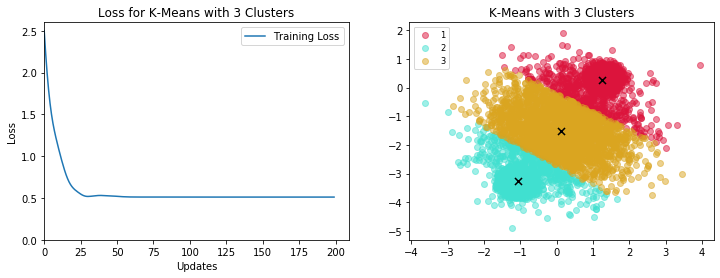

In [25]:
K = 3

# getting data
train_data = load_2D(valid=False)

# compute optimal model parameters
MU, train_loss = Kmeans(K, train_data, epochs=200)

# getting clusters
S = get_clusters_Kmeans(K, MU, train_data)

# displaying model parameters
print("MU:")
print(MU)

print("\n")

# plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
colors = ['crimson', 'turquoise', 'goldenrod', 'lightcoral', 'yellowgreen']
plot_loss(train_loss, title=f"Loss for K-Means with {K} Clusters", ax=ax[0])
plot_cluster(K, MU, S, title=f"K-Means with {K} Clusters", colors=colors, ax=ax[1])

\newpage

### 1.1.2 Varying K and 1.1.3 Validation {-}








K = 1
					Training		Validation
		Cluster 1:		 100.00%  		  100.00%

		Final Loss:		 3.8499  		  3.8368


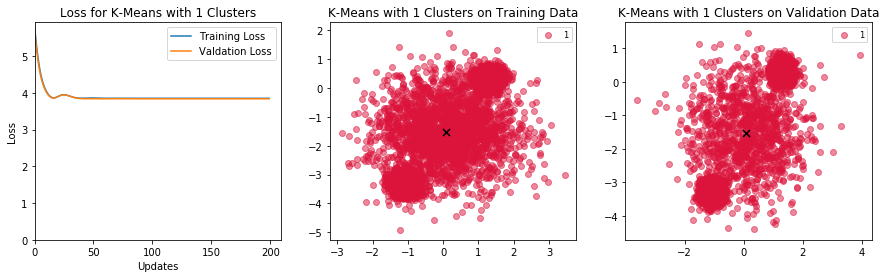

K = 2
					Training		Validation
		Cluster 1:		 49.17%  		  50.32%
		Cluster 2:		 50.83%  		  49.68%

		Final Loss:		 0.9138  		  0.9337


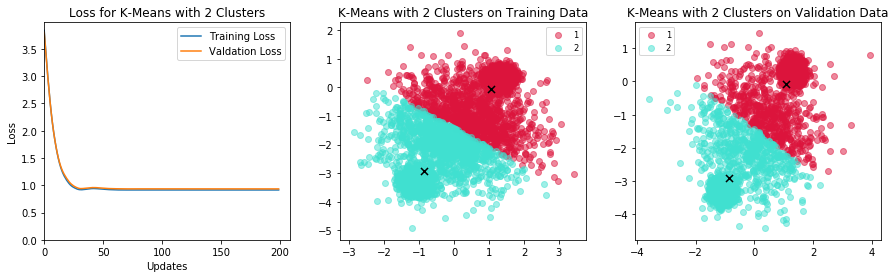

K = 3
					Training		Validation
		Cluster 1:		 38.40%  		  37.53%
		Cluster 2:		 23.77%  		  24.00%
		Cluster 3:		 37.83%  		  38.46%

		Final Loss:		 0.5032  		  0.5271


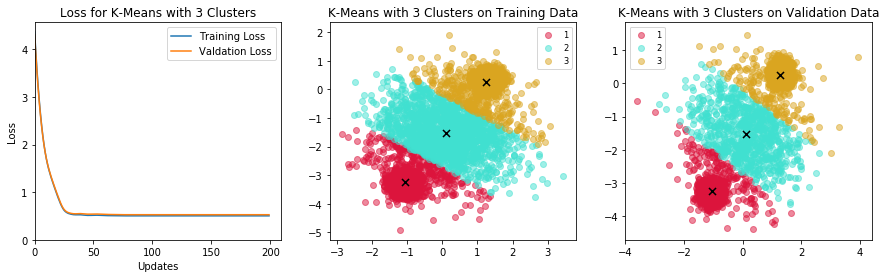

K = 4
					Training		Validation
		Cluster 1:		 12.81%  		  14.13%
		Cluster 2:		 37.53%  		  36.27%
		Cluster 3:		 37.21%  		  37.44%
		Cluster 4:		 12.45%  		  12.15%

		Final Loss:		 0.3309  		  0.3512


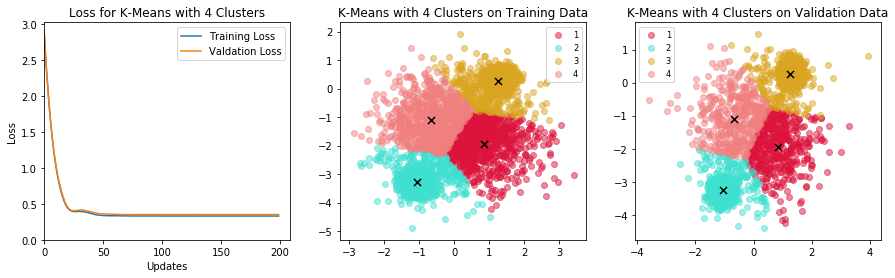

K = 5
					Training		Validation
		Cluster 1:		 36.31%  		  36.60%
		Cluster 2:		 36.10%  		  34.89%
		Cluster 3:		 8.56%  		  9.33%
		Cluster 4:		 8.14%  		  8.61%
		Cluster 5:		 10.87%  		  10.56%

		Final Loss:		 0.2804  		  0.2946


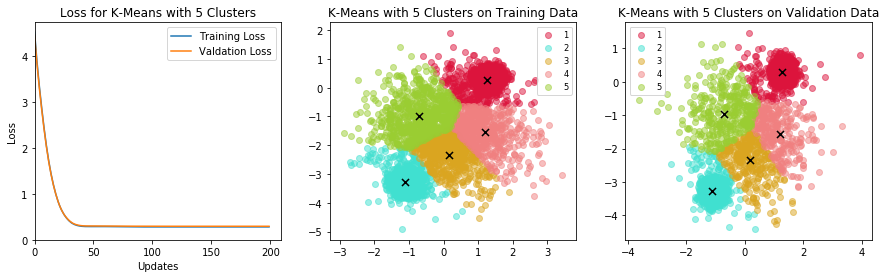

In [26]:
# getting data
train_data, valid_data = load_2D()

print("\n\n\n\n\n\n") # this just makes things look better in the pdf

# Iterate through values of K
for K in [1, 2, 3, 4, 5]:
    print("K =", K)
    
    # compute optimal model parameters
    MU, train_loss, valid_loss = Kmeans(K, train_data, valid_data, epochs=200)
    
    # getting clusters
    S_train = get_clusters_Kmeans(K, MU, train_data)
    S_valid = get_clusters_Kmeans(K, MU, valid_data)
    
    # computer percentages
    train_percentages = cluster_percentages(K, S_train)
    valid_percentages = cluster_percentages(K, S_valid)
    print("\t\t\t\t\tTraining\t\tValidation")
    for i in range(K):
        print(f"\t\tCluster {i+1}:\t\t {train_percentages[i]:.2%}  \t\t  {valid_percentages[i]:.2%}")
    print()
    print(f"\t\tFinal Loss:\t\t {train_loss[-1]:.4f}  \t\t  {valid_loss[-1]:.4f}")
    
    # plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    colors = ['crimson', 'turquoise', 'goldenrod', 'lightcoral', 'yellowgreen']
    plot_loss(train_loss, valid_loss, title=f"Loss for K-Means with {K} Clusters", ax=ax[0])
    plot_cluster(K, MU, S_train, title=f"K-Means with {K} Clusters on Training Data", colors=colors, ax=ax[1])
    plot_cluster(K, MU, S_valid, title=f"K-Means with {K} Clusters on Validation Data", colors=colors, ax=ax[2])
    plt.show()
    plt.close()
    

#### Discussion
The best number of clusters seems to be 3. Looking at the data, we see two highly dense clusters: one on the top right and one in the bottom left. Aside from these two distinct clusters, the rest of the data seems to be a noisy cluster centered around (0, -1). For all the plots where we choose K $\geq$ 3, the two dense clusters always seem to appear. Increasing K beyond 3 only partitions the big middle cluster. For plots with K $>$ 3, however, the cluster centers don't appear to be near any centered bunch of data. Instead, they seem to only split up a larger cluster.

Considering K $<$ 3, K $=$ 1 misses distinguish between the two highly dense clusters. Also, K $=$ 2 appears to include points beyond the highly dense cluster (i.e. around half of the points which appear to be outside of the main two clusters are accidentally included).

\newpage

# 2 Mixtures of Gaussians {-}

## 2.1 The Guassian Cluster Model {-}

In [11]:
def distanceFunc_GMM(X, MU):    
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the pairwise distance matrix (NxK)
    
    # expand dimensions to properly subract the two
    X_expanded = tf.expand_dims(X, 1)
    MU_expanded = tf.expand_dims(MU, 0)
    
    # uses broadcasting to do the subtraction
    pair_dist = tf.reduce_sum(tf.square(tf.subtract(X_expanded, MU_expanded)), axis=2)
    
    return tf.sqrt(pair_dist)

def log_GaussPDF(X, MU, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K
    _, D = X.shape
    
    try:
        D = D.value  # D is a tensorflow variable
    except:
        pass
    
    constants = -(D/2) * tf.log(2 * np.pi * tf.transpose(sigma)**2)
    pair_dist = distanceFunc_GMM(X, MU)
    return constants - tf.square(pair_dist) / (2 * tf.transpose(sigma)**2)


def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K
    
    log_post = tf.add(log_PDF, tf.transpose(log_pi))
    correction = reduce_logsumexp(log_post, keep_dims=True)
    return tf.subtract(log_post, correction)

*Importance of logsumexp:* For numerical stability computational efficiency, we deal with the log of the probabilities instead of the actual probabilities themselves (i.e. we deal with the probabilites in log-domain). In order to computer the posterior, we must take a sum of the actual probabilites. In general, we are looking for some operation $\odot$ which we can do in log-domain which will be able to give us the result($P_1 + P_2$) in log-domain. Specifically, we want an operation $\odot$ such that $\log(P_1) \odot \log(P_2) = \log(P_1 + P_2)$. Unfortunately, we don't know of a simple $\odot$ that meets this condition. So, we will perform this summation outside of log-domain. The function $\texttt{logsumexp}$ will first perform $e^x$ for each term $x$ to get out of log-domain. Then, it will perform the desired sum. Finally, it will perform $\log(x)$ for each term $x$ to get back into log-domain.

Essentially, $\texttt{logsumexp}$ is a way of adding two numbers in log-domain while ensuring the result is also in log-domain.

## 2.2 Learning the MoG {-}
### 2.2.1 Creating Model {-}

In [12]:
# loss function
def L_GMM(log_PDF, log_pi):
    likelihood = reduce_logsumexp(tf.add(log_PDF, tf.transpose(log_pi)))
    return -tf.reduce_sum(likelihood)

def load_GMM(K, dims):
    N, D = dims
    X = tf.placeholder(tf.float64, shape=(None,D))

    with tf.variable_scope("Part2", reuse=tf.AUTO_REUSE):
        # init with random MU
        MU = tf.Variable(tf.truncated_normal((K, D), mean=0, stddev=1, dtype=tf.float64), trainable=True)
        phi = tf.Variable(tf.truncated_normal((K,), mean=0, stddev=1, dtype=tf.float64), trainable=True)
        psi = tf.Variable(tf.truncated_normal((K,), mean=0, stddev=1, dtype=tf.float64), trainable=True)
        
        # turing the unconstrained parameters into the constrained ones
        sigma = tf.exp(phi)
        log_pi = logsoftmax(psi)
        
        # computing log probability distributions
        log_PDF = log_GaussPDF(X, MU, sigma)
        
        loss = L_GMM(log_PDF, log_pi)    # loss function

        # set up Adam optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)
    
    return optimizer, loss, X, MU, sigma, log_pi

def GMM(K, train_data, valid_data=None, epochs=10):
    train_loss = []
    valid_loss = []
    
    # load model
    optimizer, loss, X, MU, sigma, log_pi = load_GMM(K, train_data.shape)

    # train
    with tf.Session() as sess:
        # init all variables (needed for Adam)
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            # print("Epoch {}".format(epoch+1))

            # run through optimizer and update loss values
            sess.run(optimizer, feed_dict={X: train_data})
            train_loss.append(sess.run(loss, feed_dict={X: train_data}))

            if not valid_data is None:
                valid_loss.append(sess.run(loss, feed_dict={X: valid_data}))
        
        # get final MUs
        MU_optim, sigma_optim, log_pi_optim = sess.run([MU, sigma, log_pi], feed_dict={X: train_data})
    
    
    train_loss = np.array(train_loss) / train_data.shape[0]       # normalizing loss
    statistics = (train_loss, )
    if not valid_data is None:
        valid_loss = np.array(valid_loss) / valid_data.shape[0]   # normalizing loss
        statistics += (valid_loss, )
    
    # returning optimal values of parameters and loss statistics
    out = (MU_optim, sigma_optim, log_pi_optim, *statistics)
    return out

\newpage

#### Training

MU:
[[ 0.10594228 -1.52745008]
 [ 1.29862139  0.30915046]
 [-1.10177726 -3.30616363]]


sigma: [0.99358263 0.1971184  0.19771197]


pi: [0.33457562 0.33346343 0.33196095]




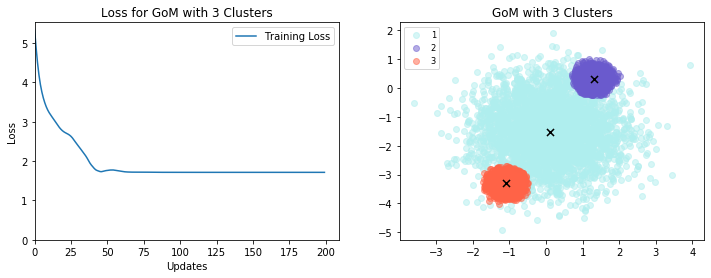

In [14]:
K = 3

# getting data
train_data = load_2D(valid=False)

# compute optimal model parameters
MU, sigma, log_pi, train_loss = GMM(K, train_data, epochs=200)

# getting clusters
#S = get_clusters_Kmeans(K, MU, train_data)
S = get_clusters_GMM(K, MU, sigma, log_pi, train_data)

# displaying model parameters
print("MU:")
print(MU)

print("\n")

print("sigma:", sigma)

print("\n")

print("pi:", np.exp(log_pi))

print("\n")

# plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
colors = ['paleturquoise', 'slateblue', 'tomato', 'orange', 'darkcyan']
plot_loss(train_loss, title=f"Loss for GoM with {K} Clusters", ax=ax[0])
plot_cluster(K, MU, S, title=f"GoM with {K} Clusters", colors=colors, ax=ax[1])

\newpage

### 2.2.2 Varying K {-}

K = 1


					Training		Validation
		Final Loss:		 3.4928  		  3.4894


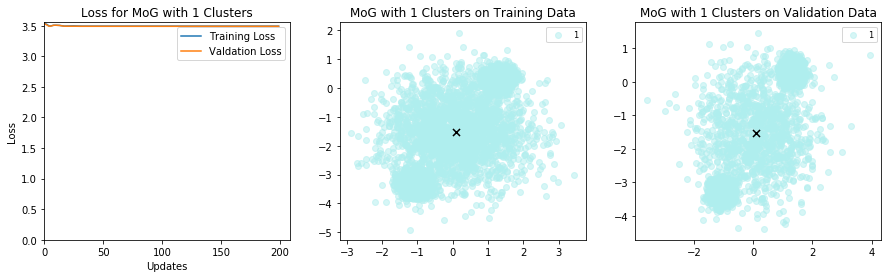

K = 2


					Training		Validation
		Final Loss:		 2.4107  		  2.4602


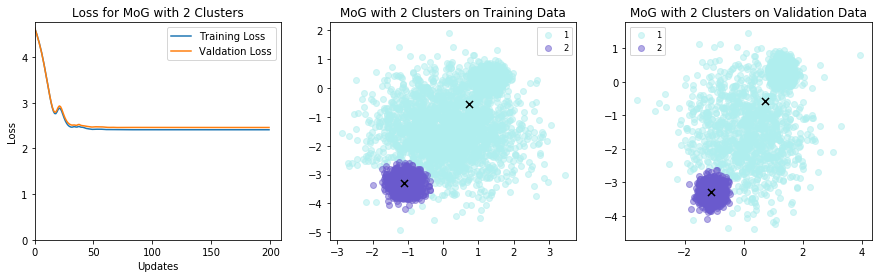

K = 3


					Training		Validation
		Final Loss:		 1.7007  		  1.7387


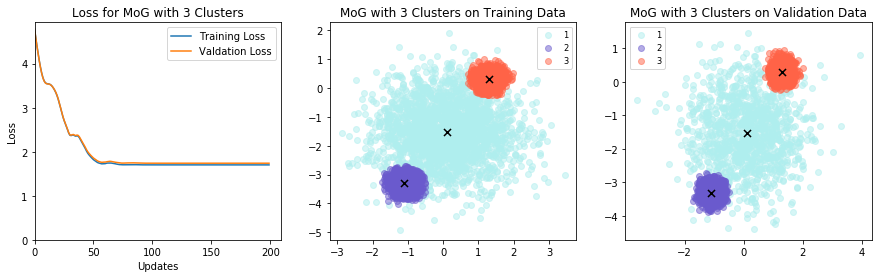

K = 4


					Training		Validation
		Final Loss:		 1.7006  		  1.7391


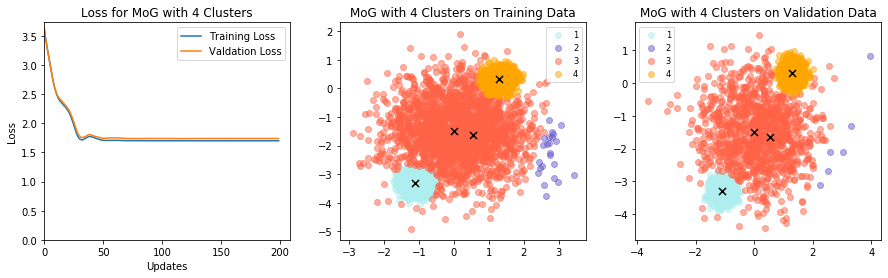

K = 5


					Training		Validation
		Final Loss:		 1.7006  		  1.7391


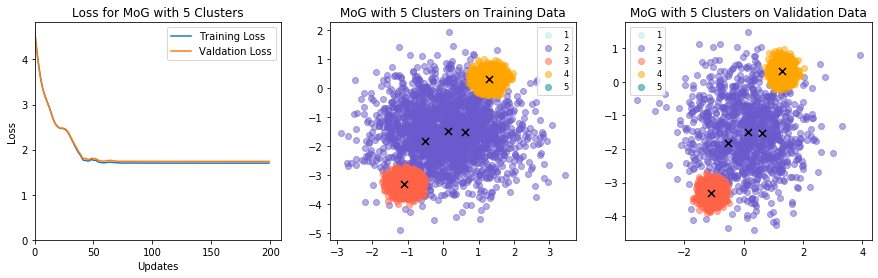

In [22]:
# getting data
train_data, valid_data = load_2D()

# Iterate through values of K
for K in [1, 2, 3, 4, 5]:
    print("K =", K)
    
    # compute optimal model parameters
    MU, sigma, log_pi, train_loss, valid_loss = GMM(K, train_data, valid_data, epochs=200)
    
    # getting clusters
    S_train = get_clusters_GMM(K, MU, sigma, log_pi, train_data)
    S_valid = get_clusters_GMM(K, MU, sigma, log_pi, valid_data)
    
    print("\n")
    print("\t\t\t\t\tTraining\t\tValidation")
    print(f"\t\tFinal Loss:\t\t {train_loss[-1]:.4f}  \t\t  {valid_loss[-1]:.4f}")
    
    # plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    colors = ['paleturquoise', 'slateblue', 'tomato', 'orange', 'darkcyan']
    plot_loss(train_loss, valid_loss, title=f"Loss for MoG with {K} Clusters", ax=ax[0])
    plot_cluster(K, MU, S_train, title=f"MoG with {K} Clusters on Training Data", colors=colors, ax=ax[1])
    plot_cluster(K, MU, S_valid, title=f"MoG with {K} Clusters on Validation Data", colors=colors, ax=ax[2])
    plt.show()
    plt.close()

#### Discussion
In the plots with the GMM (Gaussian Mixture Model), we see a similar result as compared to the K-means result but considerably more pronounced since the GMM clusters take in the adjustable prior and are probabilistic instead of forcing each data point to be assigned to the closest cluster. This allows for a more well defined clusters than when compared with the K-means case.

Clearly, with only one cluster, everything is assigned to the same cluster. With K $=$ 2, we see something more interesting. The GMM is able to very accurately find one of the two highly dense clusters (in our example, it found the bottom left one). Despite the location of the dense cluster center, we observe that some points which are closer to the dense cluster center are actually assigned to the other cluster! This is very different from the K-means case. The GMM model here seems to represent the situation much better as these far points are more likely just outliers of the center cluster than points belonging to the dense cluster.

With K $=$ 3, we see the GMM clearly find the two highly dense clusters and also identify the other points to the central cluster, as we expected the data to be labelled. Increasing beyond K $=$ 3, we only see that new cluster centers are being assigned to the central cluster. This seems redundant as the two centers appear to refer to the same central cluster (the one identified by K $=$ 3. This problem only gets worse with increasing K. As such, K $=$ 3 appears to be the best choice for this data.

\newpage

### 2.2.3 Big Dataset {-}

K = 5
					Training		Validation
		K-Means Final Loss:	 36.7704  		  37.3211
		MoG Final Loss:		 105.5101  		  104.6576


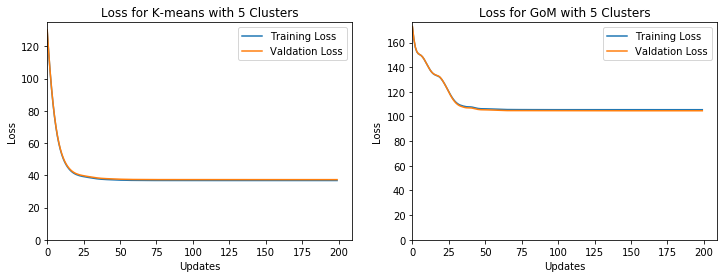

K = 10
					Training		Validation
		K-Means Final Loss:	 20.8439  		  21.4683
		MoG Final Loss:		 48.3242  		  49.3468


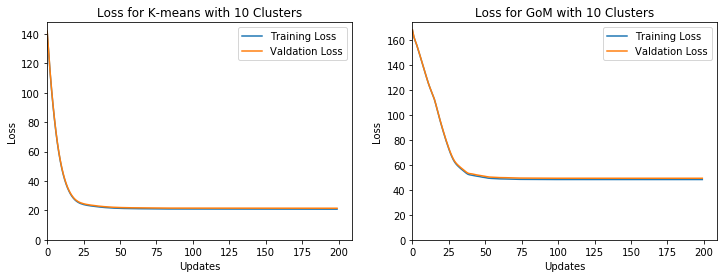

K = 15
					Training		Validation
		K-Means Final Loss:	 20.6727  		  21.2806
		MoG Final Loss:		 48.1022  		  49.1753


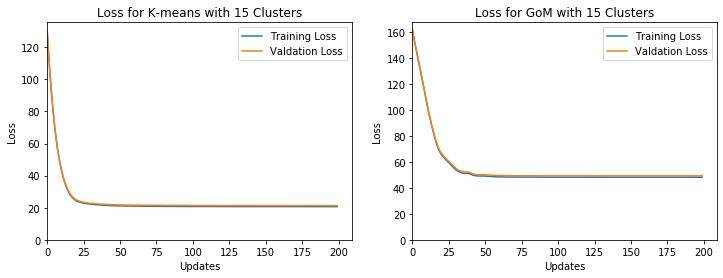

K = 20
					Training		Validation
		K-Means Final Loss:	 20.5803  		  21.2009
		MoG Final Loss:		 85.3672  		  86.5378


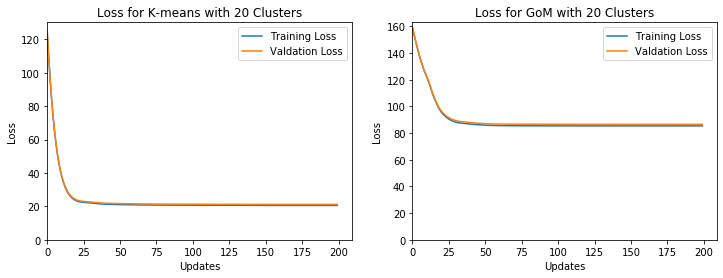

K = 30
					Training		Validation
		K-Means Final Loss:	 20.3371  		  21.0412
		MoG Final Loss:		 48.0222  		  49.1385


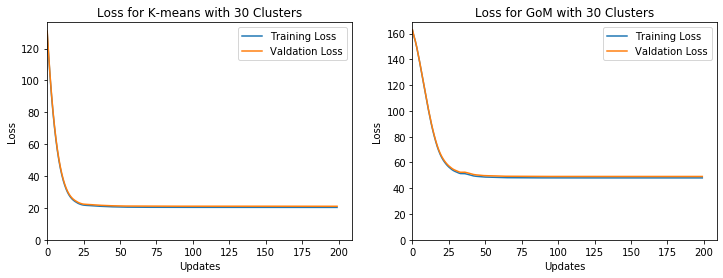

In [23]:
# getting data
train_data, valid_data = load_100D()

# Iterate through values of K
for K in [5, 10, 15, 20, 30]:
    print("K =", K)
    
    # compute optimal model parameters
    MU, Kmeans_train_loss, Kmeans_valid_loss = Kmeans(K, train_data, valid_data, epochs=200)
    MU, sigma, log_pi, GoM_train_loss, GoM_valid_loss = GMM(K, train_data, valid_data, epochs=200)
    
    print("\t\t\t\t\tTraining\t\tValidation")
    print(f"\t\tK-Means Final Loss:\t {Kmeans_train_loss[-1]:.4f}  \t\t  {Kmeans_valid_loss[-1]:.4f}")
    print(f"\t\tMoG Final Loss:\t\t {GoM_train_loss[-1]:.4f}  \t\t  {GoM_valid_loss[-1]:.4f}")
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_loss(Kmeans_train_loss, Kmeans_valid_loss, title=f"Loss for K-means with {K} Clusters", ax=ax[0])
    plot_loss(GoM_train_loss, GoM_valid_loss, title=f"Loss for GoM with {K} Clusters", ax=ax[1])
    plt.show()
    plt.close()

#### Discussion
TODO: Argue why there 